<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Environment Setup (imports, seed fixing, save path)

import os
import sys
import random
import numpy as np
import pandas as pd

# Reproducibility: fix random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Base save path for results
if "google.colab" in sys.modules:
    from google.colab import drive
    print("\n[INFO] Google Colab detected. Mounting Google Drive...")
    drive.mount("/content/drive")
    base_save_path = "/content/drive/MyDrive/geoexosome_results"
    print(f"[INFO] Drive mounted. Saving results to: {base_save_path}")
else:
    base_save_path = "./geoexosome_results"
    print(f"\n[INFO] Local environment detected. Saving results to: {base_save_path}")

os.makedirs(base_save_path, exist_ok=True)

print("=" * 60)
print("Environment setup complete!")
print(f"Results will be stored in: {base_save_path}")
print("=" * 60)



[INFO] Google Colab detected. Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Drive mounted. Saving results to: /content/drive/MyDrive/geoexosome_results
Environment setup complete!
Results will be stored in: /content/drive/MyDrive/geoexosome_results


In [2]:
# Cell 1: Library installation (optional) and imports

# If running on Colab for the first time, uncomment the line below:
!pip install GEOparse imbalanced-learn shap seaborn matplotlib

import os
import sys
import random
import numpy as np
import pandas as pd

import GEOparse

from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_predict,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
import shap

sns.set(style="whitegrid", font_scale=1.2)

print("\n[INFO] All libraries successfully imported.")



[INFO] All libraries successfully imported.


In [3]:
# Cell 2: Load GEO dataset (GSE39833) and build raw expression matrix + probe→miRNA mapping

gse_id = "GSE39833"
print(f"\n[INFO] Loading GEO dataset: {gse_id}")

gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir="./data",
    annotate_gpl=True
)

print(f"[INFO] Number of GSM samples: {len(gse.gsms)}")
print(f"[INFO] Number of GPL platforms: {len(gse.gpls)}")

# -------------------------------------------------------------
# 1) Extract expression matrix and sample labels
# -------------------------------------------------------------
samples = []
expression_rows = []
labels = []

for gsm_name, gsm in gse.gsms.items():

    tbl = gsm.table
    if "VALUE" not in tbl.columns:
        print(f"[WARNING] {gsm_name} missing VALUE column. Skipped.")
        continue

    expr_vals = tbl["VALUE"].astype(float).values
    expression_rows.append(expr_vals)
    samples.append(gsm_name)

    # A) PRIMARY LABELING: Use Sample Title (most reliable)
    title_list = gsm.metadata.get("title", [""])
    title = title_list[0].lower()

    if title.startswith("hc_"):        # Healthy controls
        label_value = 0
    elif title.startswith("crc"):      # CRC patients (CRC1, CRC2, CRC3a, CRC3b, CRC4)
        label_value = 1
    else:
        label_value = None  # Unknown — fallback to metadata parsing

    # B) FALLBACK: Use metadata characteristics (TNM stage, cancer keywords)
    if label_value is None:
        characteristics = gsm.metadata.get("characteristics_ch1", []) + \
                          gsm.metadata.get("characteristics_ch2", [])
        chars_low = [c.lower() for c in characteristics]

        # Cancer indicators
        if any(("tnm" in c or "stage" in c or "cancer" in c or "adenocarcinoma" in c) for c in chars_low):
            label_value = 1
        # Healthy indicators
        elif any(("healthy" in c or "control" in c or "normal" in c) for c in chars_low):
            label_value = 0
        else:
            raise ValueError(
                f"[ERROR] Could not determine label for {gsm_name}. "
                f"Title: {title_list}, Metadata: {characteristics}"
            )

    labels.append(label_value)

expression_data = np.vstack(expression_rows)

# -------------------------------------------------------------
# 2) Build df_expression DataFrame (raw expression, probe-level)
# -------------------------------------------------------------
first_gsm = gse.gsms[samples[0]]
probe_ids = first_gsm.table["ID_REF"].tolist()

df_expression = pd.DataFrame(
    expression_data,
    columns=probe_ids,
    index=samples
)
df_expression["label"] = labels

print("\n[INFO] df_expression overview:")
print("Shape:", df_expression.shape)
print("Label distribution:\n", df_expression["label"].value_counts())

# -------------------------------------------------------------
# 3) Probe → miRNA mapping using GPL
# -------------------------------------------------------------
print("\n[INFO] Loading platform (GPL) annotation for probe → miRNA mapping...")

gpl = list(gse.gpls.values())[0]
gpl_table = gpl.table

if "ID" not in gpl_table.columns:
    raise KeyError("[ERROR] GPL table missing 'ID' column.")

# Look for a column containing miRNA names
mirna_cols = [c for c in gpl_table.columns if "mir" in c.lower()]

if len(mirna_cols) == 0:
    print("[WARNING] No miRNA column detected in GPL. Mapping skipped.")
    mapping_df = None
else:
    mirna_col = mirna_cols[0]
    print(f"[INFO] Using miRNA annotation column: {mirna_col}")

    probe_to_mirna = dict(zip(gpl_table["ID"], gpl_table[mirna_col]))
    mirna_names = [probe_to_mirna.get(pid, np.nan) for pid in probe_ids]

    mapping_df = pd.DataFrame({
        "ProbeID": probe_ids,
        "miRNA": mirna_names
    })

    mapping_path = os.path.join(base_save_path, "probe_to_miRNA_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    print(f"[INFO] Probe → miRNA mapping saved to: {mapping_path}")

print("\n[INFO] GSE39833 preprocessing complete (raw, probe-level).")


16-Nov-2025 12:32:56 DEBUG utils - Directory ./data already exists. Skipping.
DEBUG:GEOparse:Directory ./data already exists. Skipping.
16-Nov-2025 12:32:56 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
16-Nov-2025 12:32:56 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz: 
INFO:GEOparse:Parsing ./data/GSE39833_family.soft.gz: 
16-Nov-2025 12:32:56 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
16-Nov-2025 12:32:56 DEBUG GEOparse - SERIES: GSE39833
DEBUG:GEOparse:SERIES: GSE39833
16-Nov-2025 12:32:56 DEBUG GEOparse - PLATFORM: GPL14767
DEBUG:GEOparse:PLATFORM: GPL14767



[INFO] Loading GEO dataset: GSE39833


16-Nov-2025 12:32:56 DEBUG GEOparse - SAMPLE: GSM980024
DEBUG:GEOparse:SAMPLE: GSM980024
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980025
DEBUG:GEOparse:SAMPLE: GSM980025
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980026
DEBUG:GEOparse:SAMPLE: GSM980026
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980027
DEBUG:GEOparse:SAMPLE: GSM980027
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980028
DEBUG:GEOparse:SAMPLE: GSM980028
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980029
DEBUG:GEOparse:SAMPLE: GSM980029
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980030
DEBUG:GEOparse:SAMPLE: GSM980030
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980031
DEBUG:GEOparse:SAMPLE: GSM980031
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980032
DEBUG:GEOparse:SAMPLE: GSM980032
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980033
DEBUG:GEOparse:SAMPLE: GSM980033
16-Nov-2025 12:32:57 DEBUG GEOparse - SAMPLE: GSM980034
DEBUG:GEOparse:SAMPLE: GSM980034
16-Nov-2025 12:32:57 

[INFO] Number of GSM samples: 99
[INFO] Number of GPL platforms: 1

[INFO] df_expression overview:
Shape: (99, 15740)
Label distribution:
 label
1    88
0    11
Name: count, dtype: int64

[INFO] Loading platform (GPL) annotation for probe → miRNA mapping...
[INFO] Using miRNA annotation column: miRNA_ID
[INFO] Probe → miRNA mapping saved to: /content/drive/MyDrive/geoexosome_results/probe_to_miRNA_mapping.csv

[INFO] GSE39833 preprocessing complete (raw, probe-level).



Expression normalization, QC, feature selection, and miRNA-level aggregation
[INFO] Applying log2(x + 1) transform to expression values.


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


[INFO] Applying quantile normalization across samples (NaN-safe)...


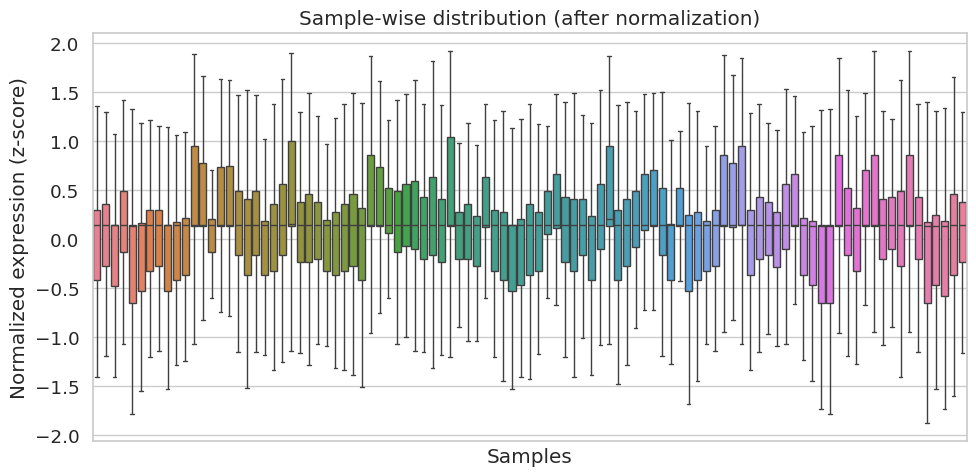

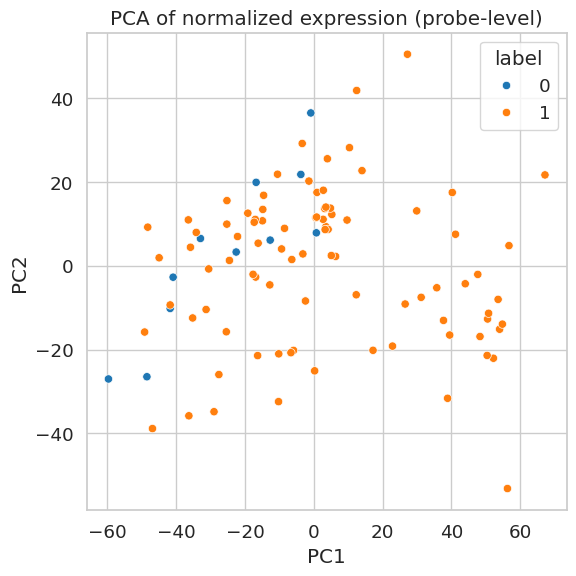

[INFO] X shape after feature selection: (99, 1000)
[INFO] Label distribution: [11 88]
[INFO] Aggregating miRNA-level expression...
[INFO] Cell 3 completed successfully.


In [5]:
# Cell 3:
# Normalization + QC + Feature selection + miRNA-level expression aggregation

from sklearn.decomposition import PCA

print("\n" + "=" * 80)
print("Expression normalization, QC, feature selection, and miRNA-level aggregation")
print("=" * 80)

# ----------------------------------------------------------------
# 1. Split expression and labels
# ----------------------------------------------------------------
expr_raw = df_expression.drop(columns=["label"]).copy()
labels = df_expression["label"].astype(int).values
sample_ids = df_expression.index.tolist()

# Ensure numeric
expr_raw = expr_raw.apply(pd.to_numeric, errors="coerce")

# Drop probes with all NaN
expr_raw = expr_raw.dropna(axis=1, how="all")

# Replace remaining NaNs with probe-wise median
expr_raw = expr_raw.fillna(expr_raw.median(axis=0))

# ----------------------------------------------------------------
# 2. Log2 transform (safe) + quantile normalization + z-score
# ----------------------------------------------------------------
# Safe log2 transform
if expr_raw.values.max() > 20:
    print("[INFO] Applying log2(x + 1) transform to expression values.")
    expr_log = np.log2(expr_raw + 1.0)
else:
    print("[INFO] Values appear already log-transformed. Skipping log2.")
    expr_log = expr_raw.copy()

# Replace inf, -inf after log2
expr_log = expr_log.replace([np.inf, -np.inf], np.nan)
expr_log = expr_log.fillna(expr_log.median(axis=0))


# -------- Quantile Normalization (NaN-safe version) ----------
def quantile_normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Quantile normalization (NaN-safe).
    """
    df = df.copy()
    # Ensure float dtype
    df = df.astype(float)

    # Rank columns (NaN → largest rank)
    ranks = df.rank(axis=0, method="average", na_option="bottom")

    # Sort each column
    sorted_vals = np.sort(df.values, axis=0)

    # Mean across columns for each rank
    mean_sorted = np.nanmean(sorted_vals, axis=1)

    # Apply quantile mapping
    qn = df.copy()
    for col in df.columns:
        qn[col] = ranks[col].apply(lambda r: mean_sorted[int(r) - 1])

    return qn


print("[INFO] Applying quantile normalization across samples (NaN-safe)...")
expr_qn = quantile_normalize(expr_log)

# Z-score normalization per probe
expr_norm = (expr_qn - expr_qn.mean(axis=0)) / expr_qn.std(axis=0, ddof=0)

# Replace zero-variance NaN
expr_norm = expr_norm.fillna(0.0)

# ----------------------------------------------------------------
# 3. QC plots
# ----------------------------------------------------------------
qc_dir = os.path.join(base_save_path, "qc")
os.makedirs(qc_dir, exist_ok=True)

# Boxplot of sample-wise expression
plt.figure(figsize=(10, 5))
sns.boxplot(data=expr_norm.T, whis=1.5, showfliers=False)
plt.xlabel("Samples")
plt.ylabel("Normalized expression (z-score)")
plt.title("Sample-wise distribution (after normalization)")
plt.xticks([], [])
plt.tight_layout()
plt.savefig(os.path.join(qc_dir, "sample_boxplot_normalized.png"), dpi=300)
plt.show()

# PCA QC
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(expr_norm.values)
df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "label": labels
}, index=sample_ids)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="label",
                palette={0: "tab:blue", 1: "tab:orange"})
plt.title("PCA of normalized expression (probe-level)")
plt.tight_layout()
plt.savefig(os.path.join(qc_dir, "pca_probe_level.png"), dpi=300)
plt.show()

# ----------------------------------------------------------------
# 4. Feature selection (variance-based)
# ----------------------------------------------------------------
n_total_probes = expr_norm.shape[1]
TOP_K_PROBES = min(1000, n_total_probes)

probe_var = expr_norm.var(axis=0)
top_probes = probe_var.nlargest(TOP_K_PROBES).index.tolist()

expr_model = expr_norm[top_probes].copy()

feature_cols = top_probes
X = expr_model.values
y = labels

print(f"[INFO] X shape after feature selection: {X.shape}")
print(f"[INFO] Label distribution: {np.bincount(y)}")

# ----------------------------------------------------------------
# 5. miRNA-level aggregation
# ----------------------------------------------------------------
df_miRNA_expr = None

if mapping_df is None:
    print("[WARNING] No probe→miRNA mapping found.")
else:
    print("[INFO] Aggregating miRNA-level expression...")
    mapping_valid = mapping_df.dropna(subset=["miRNA"])
    mapping_valid = mapping_valid[mapping_valid["ProbeID"].isin(feature_cols)]

    if mapping_valid.empty:
        print("[WARNING] No overlap between selected probes and miRNA mapping.")
    else:
        mirna_to_probes = mapping_valid.groupby("miRNA")["ProbeID"].apply(list)

        mirna_expr = {
            mir: expr_model[probes].mean(axis=1)
            for mir, probes in mirna_to_probes.items()
        }

        df_miRNA_expr = pd.DataFrame(mirna_expr, index=sample_ids)
        df_miRNA_expr["label"] = labels

        df_miRNA_expr.to_csv(
            os.path.join(base_save_path, "miRNA_expression_normalized.csv")
        )

print("[INFO] Cell 3 completed successfully.")


In [6]:
# Cell 4
# - Outer CV (3-fold): unbiased performance estimation
# - Inner CV (3-fold): hyperparameter optimization
# - SMOTE(k=2): handles class imbalance in small-sample setting
# - Tree-based model (RandomForest) without scaling
# - SVM / Logistic Regression with StandardScaler + SMOTE
# - Multiple performance metrics (AUC, Acc, BalAcc, Precision, Recall,
#   F1-score, Sensitivity, Specificity) + bootstrap 95% CI for AUC
# - Final model training (for interpretation/SHAP only) clearly separated

import json

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy import stats  # for bootstrap CI

# ----------------------------------------------------------------
# 0. Reproducibility: set all seeds (SEED already defined in Cell 0)
# ----------------------------------------------------------------
try:
    SEED
except NameError:
    SEED = 42

np.random.seed(SEED)
random.seed(SEED)

print("\n" + "=" * 80)
print("Nested Cross-Validation (3x3) with SMOTE(k=2) — Model Comparison and Selection")
print("=" * 80)

# ----------------------------------------------------------------
# 1. CV settings (3-fold nested CV is appropriate for n≈100 biomedical data)
# ----------------------------------------------------------------
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# ----------------------------------------------------------------
# 2. Define candidate models and hyperparameter grids
# ----------------------------------------------------------------
models = {}

# 2.1 Random Forest (tree-based, no scaler)
models["RandomForest"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
        ("clf", RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]),
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt", "log2"]
    }
}

# 2.2 SVM with RBF kernel (requires scaling)
models["SVM"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
        ("scaler", StandardScaler()),
        ("clf", SVC(
            probability=True,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
}

# 2.3 Logistic Regression (requires scaling)
models["LogisticRegression"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=500,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }
}

# ----------------------------------------------------------------
# 3. Utility: Bootstrap 95% CI for ROC-AUC
# ----------------------------------------------------------------
def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=SEED):
    """
    Compute bootstrap confidence interval for ROC-AUC.
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        if len(np.unique(y_true[indices])) < 2:
            # Skip bootstrap samples with only one class
            continue
        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return float(lower), float(upper)

# ----------------------------------------------------------------
# 4. Nested CV loop: out-of-fold predictions + rich metrics for each model
# ----------------------------------------------------------------
results = {}
oof_predictions = {}

for name, cfg in models.items():
    print("\n" + "-" * 60)
    print(f"Model: {name}")
    print("-" * 60)

    # Out-of-fold predictions for the entire dataset
    oof_proba = np.zeros_like(y, dtype=float)
    oof_pred = np.zeros_like(y, dtype=int)

    # --- Outer CV loop ---
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Class distribution in each fold
        train_pos = int(y_train.sum())
        test_pos = int(y_test.sum())
        print(f"  Fold {fold_idx} class distribution:")
        print(f"    Train: {train_pos}/{len(y_train)} ({train_pos/len(y_train):.2%}) positive")
        print(f"    Test : {test_pos}/{len(y_test)} ({test_pos/len(y_test):.2%}) positive")

        # Inner CV grid search
        gs = GridSearchCV(
            estimator=cfg["pipeline"],
            param_grid=cfg["param_grid"],
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )
        gs.fit(X_train, y_train)

        # Predict on held-out outer test fold
        proba = gs.predict_proba(X_test)[:, 1]
        pred = (proba >= 0.5).astype(int)

        oof_proba[test_idx] = proba
        oof_pred[test_idx] = pred

        print(f"    Fold {fold_idx}: best inner-CV AUC = {gs.best_score_:.4f}")

    # Aggregate performance over outer folds (OOF)
    cm = confusion_matrix(y, oof_pred)
    auc = roc_auc_score(y, oof_proba)
    acc = accuracy_score(y, oof_pred)
    bal_acc = balanced_accuracy_score(y, oof_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, oof_pred, average="binary", zero_division=0
    )

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = recall  # same as recall for positive class

    # Bootstrap CI for AUC
    ci_lower, ci_upper = bootstrap_auc_ci(y, oof_proba, n_bootstrap=1000, alpha=0.05)

    print("\n  Out-of-fold performance (aggregated over 3 outer folds):")
    print(f"    ROC-AUC           : {auc:.4f}")
    print(f"    95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"    Accuracy          : {acc:.4f}")
    print(f"    Balanced Accuracy : {bal_acc:.4f}")
    print(f"    Precision         : {precision:.4f}")
    print(f"    Recall (Sensitivity): {sensitivity:.4f}")
    print(f"    Specificity       : {specificity:.4f}")
    print(f"    F1-score          : {f1:.4f}")
    print("    Confusion matrix:")
    print(cm)

    # Save results for this model (metrics only)
    results[name] = {
        "oof_auc": float(auc),
        "oof_auc_ci": [ci_lower, ci_upper],
        "oof_accuracy": float(acc),
        "oof_balanced_accuracy": float(bal_acc),
        "precision": float(precision),
        "recall_sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist(),
        "param_grid": cfg["param_grid"],
        "best_params": gs.best_params_
    }

    # Store best estimator object separately (for SHAP, not for JSON)
    results[name]["best_estimator"] = gs.best_estimator_

    # Store OOF predictions for later analysis/plots
    oof_predictions[name] = {
        "y_true": y.copy(),
        "y_proba": oof_proba,
        "y_pred": oof_pred
    }

# ----------------------------------------------------------------
# 5. Select best model based on OOF ROC-AUC (primary metric)
# ----------------------------------------------------------------
best_name = max(results, key=lambda k: results[k]["oof_auc"])

print("\n" + "=" * 80)
print("Model selection summary (based on nested OOF ROC-AUC):")
for m_name, res in results.items():
    print(f"  {m_name}: OOF AUC = {res['oof_auc']:.4f} "
          f"(95% CI [{res['oof_auc_ci'][0]:.4f}, {res['oof_auc_ci'][1]:.4f}])")
print("=" * 80)

print(f"Best model selected: {best_name}")
print(f"OOF ROC-AUC (best): {results[best_name]['oof_auc']:.4f}")
print(f"OOF Accuracy      : {results[best_name]['oof_accuracy']:.4f}")
print(f"OOF Balanced Acc  : {results[best_name]['oof_balanced_accuracy']:.4f}")
print("=" * 80)

# ----------------------------------------------------------------
# 6. Final model training (for interpretation / deployment ONLY)
# ----------------------------------------------------------------
print("\n" + "=" * 80)
print("Final model training on full dataset (for interpretation only)")
print("Note: Performance must be interpreted from nested OOF metrics above.")
print("=" * 80)

best_cfg = models[best_name]

final_model = GridSearchCV(
    estimator=best_cfg["pipeline"],
    param_grid=best_cfg["param_grid"],
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True
)
final_model.fit(X, y)

best_model = final_model.best_estimator_
best_params = final_model.best_params_

print(f"Final model (refit on full dataset): {best_name}")
print("Best hyperparameters (inner CV on full data):")
print(best_params)

# Prepare JSON-safe copy (drop non-serializable objects like pipelines)
results_json_safe = {}
for m_name, res in results.items():
    res_copy = {k: v for k, v in res.items() if k != "best_estimator"}
    results_json_safe[m_name] = res_copy

metrics_json_path = os.path.join(base_save_path, "nested_cv_model_selection_results.json")
with open(metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(
        {
            "results": results_json_safe,
            "best_model_name": best_name,
            "best_model_params": best_params
        },
        f,
        indent=2,
        ensure_ascii=False
    )

print(f"[INFO] Nested CV model selection summary saved to: {metrics_json_path}")



Nested Cross-Validation (3x3) with SMOTE(k=2) — Model Comparison and Selection

------------------------------------------------------------
Model: RandomForest
------------------------------------------------------------
  Fold 1 class distribution:
    Train: 59/66 (89.39%) positive
    Test : 29/33 (87.88%) positive
    Fold 1: best inner-CV AUC = 0.8624
  Fold 2 class distribution:
    Train: 59/66 (89.39%) positive
    Test : 29/33 (87.88%) positive
    Fold 2: best inner-CV AUC = 0.8882
  Fold 3 class distribution:
    Train: 58/66 (87.88%) positive
    Test : 30/33 (90.91%) positive
    Fold 3: best inner-CV AUC = 0.9262

  Out-of-fold performance (aggregated over 3 outer folds):
    ROC-AUC           : 0.9122
    95% CI (bootstrap): [0.8310, 0.9736]
    Accuracy          : 0.8889
    Balanced Accuracy : 0.5000
    Precision         : 0.8889
    Recall (Sensitivity): 1.0000
    Specificity       : 0.0000
    F1-score          : 0.9412
    Confusion matrix:
[[ 0 11]
 [ 0 88]]

-

In [7]:
# Cell 5 :
# Overfitting check using train vs test ROC-AUC
# based on the selected best model and the same outer CV splits.

from sklearn.model_selection import cross_validate

print("\n" + "=" * 70)
print("Overfitting assessment for the selected model")
print("=" * 70)

cv_scores = cross_validate(
    best_model,
    X, y,
    cv=outer_cv,
    scoring="roc_auc",
    return_train_score=True,
    n_jobs=-1
)

train_auc_mean = cv_scores["train_score"].mean()
test_auc_mean = cv_scores["test_score"].mean()
auc_gap = train_auc_mean - test_auc_mean

print(f"Mean Train ROC-AUC: {train_auc_mean:.4f}")
print(f"Mean Test  ROC-AUC: {test_auc_mean:.4f}")
print(f"AUC Gap (Train - Test): {auc_gap:.4f}")

if auc_gap < 0.02:
    print("→ Low risk of overfitting (train and test performance are very similar).")
elif auc_gap < 0.05:
    print("→ Mild overfitting: small but noticeable gap between train and test.")
else:
    print("→ High risk of overfitting: train performance clearly exceeds test performance.")

print("=" * 70)



Overfitting assessment for the selected model
Mean Train ROC-AUC: 1.0000
Mean Test  ROC-AUC: 0.9519
AUC Gap (Train - Test): 0.0481
→ Mild overfitting: small but noticeable gap between train and test.



Out-of-fold performance summary for: RandomForest
OOF ROC-AUC: 0.9122
OOF Accuracy: 0.8889
Confusion matrix:
[[ 0 11]
 [ 0 88]]


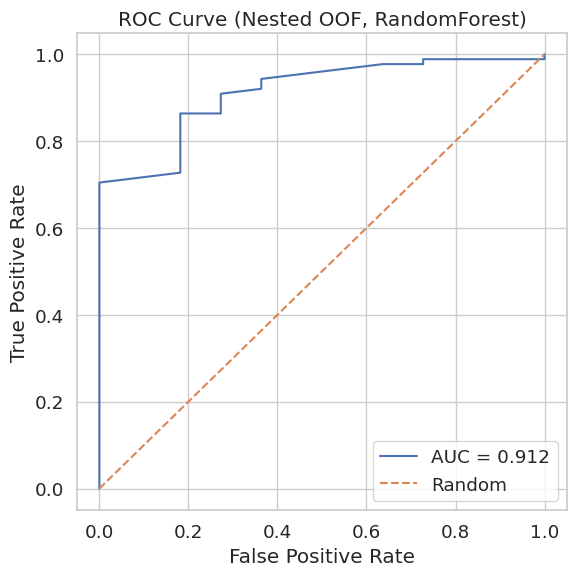

[INFO] ROC curve saved to: /content/drive/MyDrive/geoexosome_results/roc_curve_RandomForest_nested.png


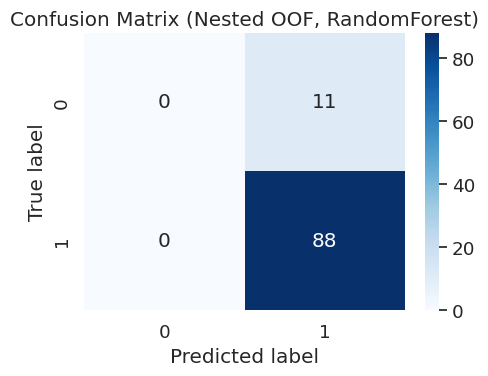

[INFO] Confusion matrix saved to: /content/drive/MyDrive/geoexosome_results/confusion_matrix_RandomForest_nested.png


In [8]:
# Cell 6:
# ROC curve and confusion matrix visualization for the selected model
# using the nested OOF predictions stored in Cell 4.

print("\n" + "=" * 70)
print(f"Out-of-fold performance summary for: {best_name}")
print("=" * 70)

y_true_best = oof_predictions[best_name]["y_true"]
y_proba_best = oof_predictions[best_name]["y_proba"]
y_pred_best = oof_predictions[best_name]["y_pred"]

auc_best = roc_auc_score(y_true_best, y_proba_best)
acc_best = accuracy_score(y_true_best, y_pred_best)
cm_best = confusion_matrix(y_true_best, y_pred_best)

print(f"OOF ROC-AUC: {auc_best:.4f}")
print(f"OOF Accuracy: {acc_best:.4f}")
print("Confusion matrix:")
print(cm_best)

# ROC curve
fpr, tpr, _ = roc_curve(y_true_best, y_proba_best)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_best:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Nested OOF, {best_name})")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = os.path.join(base_save_path, f"roc_curve_{best_name}_nested.png")
plt.savefig(roc_path, dpi=300)
plt.show()
print(f"[INFO] ROC curve saved to: {roc_path}")

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (Nested OOF, {best_name})")
plt.tight_layout()

cm_path = os.path.join(base_save_path, f"confusion_matrix_{best_name}_nested.png")
plt.savefig(cm_path, dpi=300)
plt.show()
print(f"[INFO] Confusion matrix saved to: {cm_path}")



Random Forest – feature importance and SHAP analysis
[INFO] RF feature importance saved to: /content/drive/MyDrive/geoexosome_results/rf_feature_importance_probes.csv

[INFO] Computing SHAP values for Random Forest (TreeExplainer)...
[INFO] RF SHAP-based importance saved to: /content/drive/MyDrive/geoexosome_results/rf_shap_importance_probes.csv

[INFO] Generating SHAP summary plot at probe level (top 20 features)...


/tmp/ipython-input-1455018677.py:95: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


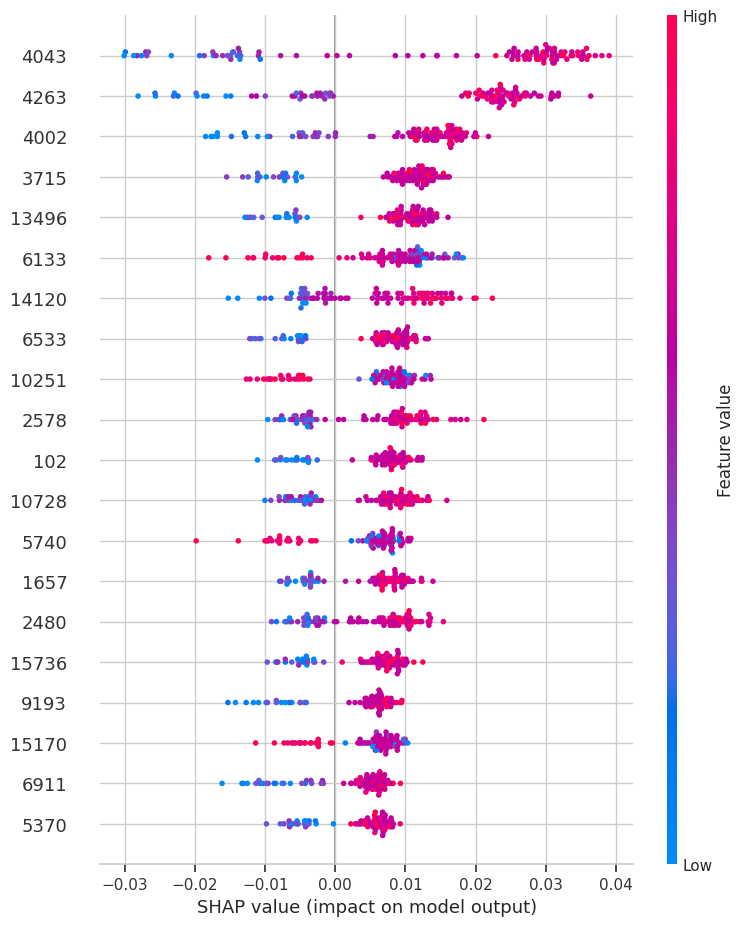

[INFO] SHAP summary plot (probe level) saved to: /content/drive/MyDrive/geoexosome_results/rf_shap_summary_top20_probes.png


In [14]:
# Cell 7:
# Random Forest-based feature importance and SHAP interpretation

print("\n" + "=" * 70)
print("Random Forest – feature importance and SHAP analysis")
print("=" * 70)

import shap
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1) Ensure RandomForest results exist
# -------------------------------------------------------------------
if "RandomForest" not in results:
    raise ValueError("RandomForest results are not available in 'results'.")

rf_params = results["RandomForest"]["best_params"]

# -------------------------------------------------------------------
# 2) Rebuild RandomForest pipeline with best parameters
#    (Pipeline: SMOTE + RF)
# -------------------------------------------------------------------
rf_best = ImbPipeline([
    ("smote", SMOTE(random_state=SEED, k_neighbors=2)),
    ("clf", RandomForestClassifier(
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample",
        n_estimators=rf_params["clf__n_estimators"],
        max_depth=rf_params["clf__max_depth"],
        max_features=rf_params["clf__max_features"]
    ))
])

rf_best.fit(X, y)
rf_clf = rf_best.named_steps["clf"]

# -------------------------------------------------------------------
# 3) RandomForest feature importance
# -------------------------------------------------------------------
rf_importances = rf_clf.feature_importances_

fi_df = pd.DataFrame({
    "ProbeID": feature_cols,
    "RF_Importance": rf_importances
}).sort_values("RF_Importance", ascending=False)

# Merge with probe→miRNA mapping (optional)
if mapping_df is not None:
    fi_df = fi_df.merge(mapping_df, on="ProbeID", how="left")

fi_path = os.path.join(base_save_path, "rf_feature_importance_probes.csv")
fi_df.to_csv(fi_path, index=False)
print(f"[INFO] RF feature importance saved to: {fi_path}")

# -------------------------------------------------------------------
# 4) SHAP value computation (TreeExplainer)
# -------------------------------------------------------------------
print("\n[INFO] Computing SHAP values for Random Forest (TreeExplainer)...")

explainer = shap.TreeExplainer(rf_clf)

# SHAP returns (n_samples, n_features, n_classes)
shap_arr = explainer.shap_values(X)

# Extract SHAP values for positive class (CRC = class 1)
# shap_arr shape: (99, 1000, 2)
shap_class1 = shap_arr[:, :, 1]     # shape: (n_samples, n_features)

# Compute mean(|SHAP|) across samples → 1D vector (n_features,)
shap_importance_vector = np.abs(shap_class1).mean(axis=0)

# -------------------------------------------------------------------
# 5) Build SHAP importance DataFrame
# -------------------------------------------------------------------
shap_df = pd.DataFrame({
    "ProbeID": feature_cols,
    "SHAP_Importance": shap_importance_vector
}).sort_values("SHAP_Importance", ascending=False)

# Merge with miRNA annotation
if mapping_df is not None:
    shap_df = shap_df.merge(mapping_df, on="ProbeID", how="left")

shap_path = os.path.join(base_save_path, "rf_shap_importance_probes.csv")
shap_df.to_csv(shap_path, index=False)
print(f"[INFO] RF SHAP-based importance saved to: {shap_path}")

# -------------------------------------------------------------------
# 6) SHAP summary plot (Top 20)
# -------------------------------------------------------------------
print("\n[INFO] Generating SHAP summary plot at probe level (top 20 features)...")

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_class1,
    X,
    feature_names=feature_cols,
    max_display=20,
    show=False
)

plt.tight_layout()
summary_path = os.path.join(base_save_path, "rf_shap_summary_top20_probes.png")
plt.savefig(summary_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"[INFO] SHAP summary plot (probe level) saved to: {summary_path}")



miRNA-level aggregation of RF and SHAP importance
[INFO] Full miRNA-level importance table saved to: /content/drive/MyDrive/geoexosome_results/miRNA_importance_aggregated.csv
[INFO] Top 5 miRNAs saved to: /content/drive/MyDrive/geoexosome_results/miRNA_importance_top5.csv

Top 5 miRNAs (by RF_Sum):
            miRNA  Num_Probes    RF_Max    RF_Sum   RF_Mean  SHAP_Max  \
86   hsa-miR-1280           1  0.043664  0.043664  0.043664  0.024669   
58   hsa-miR-1234           2  0.022200  0.033995  0.016997  0.012877   
63   hsa-miR-1246           1  0.033219  0.033219  0.033219  0.019621   
146  hsa-miR-191*           3  0.011656  0.022255  0.007418  0.007730   
113   hsa-miR-144           1  0.018611  0.018611  0.018611  0.009973   

     SHAP_Sum  SHAP_Mean  
86   0.024669   0.024669  
58   0.019950   0.009975  
63   0.019621   0.019621  
146  0.014229   0.004743  
113  0.009973   0.009973  


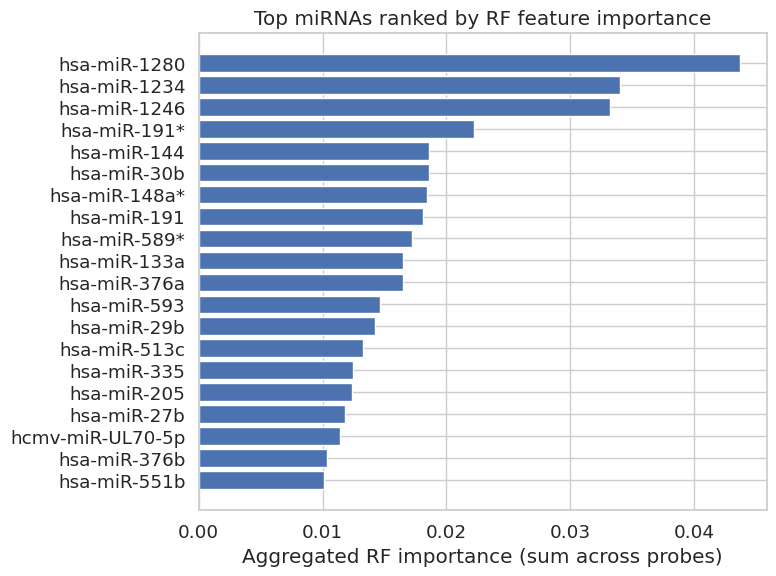

[INFO] miRNA-level RF importance bar plot saved to: /content/drive/MyDrive/geoexosome_results/miRNA_top20_RF_importance_barplot.png


In [15]:
# Cell 8 :
# Aggregate RF and SHAP importance at the miRNA level and visualize top miRNAs.

print("\n" + "=" * 70)
print("miRNA-level aggregation of RF and SHAP importance")
print("=" * 70)

if mapping_df is None:
    print("[WARNING] No probe → miRNA mapping available. Skipping miRNA-level analysis.")
else:
    # Ensure we only use rows with valid miRNA names
    fi_mi = (
        fi_df.dropna(subset=["miRNA"])
             .groupby("miRNA")["RF_Importance"]
             .agg(["count", "max", "sum", "mean"])
             .reset_index()
    )
    fi_mi.rename(columns={
        "count": "Num_Probes",
        "max": "RF_Max",
        "sum": "RF_Sum",
        "mean": "RF_Mean"
    }, inplace=True)

    shap_mi = (
        shap_df.dropna(subset=["miRNA"])
               .groupby("miRNA")["SHAP_Importance"]
               .agg(["max", "sum", "mean"])
               .reset_index()
    )
    shap_mi.rename(columns={
        "max": "SHAP_Max",
        "sum": "SHAP_Sum",
        "mean": "SHAP_Mean"
    }, inplace=True)

    miRNA_importance = fi_mi.merge(shap_mi, on="miRNA", how="left")

    # Rank by RF_Sum (primary ranking) as an example
    miRNA_importance = miRNA_importance.sort_values("RF_Sum", ascending=False)

    top_miRNAs = miRNA_importance.head(20).copy()

    agg_path = os.path.join(base_save_path, "miRNA_importance_aggregated.csv")
    miRNA_importance.to_csv(agg_path, index=False)

    top5_path = os.path.join(base_save_path, "miRNA_importance_top5.csv")
    top_miRNAs.head(5).to_csv(top5_path, index=False)

    print(f"[INFO] Full miRNA-level importance table saved to: {agg_path}")
    print(f"[INFO] Top 5 miRNAs saved to: {top5_path}")
    print("\nTop 5 miRNAs (by RF_Sum):")
    print(top_miRNAs.head(5))

    # Bar plot for top miRNAs (e.g. top 20 by RF_Sum)
    plt.figure(figsize=(8, 6))
    plt.barh(top_miRNAs["miRNA"], top_miRNAs["RF_Sum"])
    plt.gca().invert_yaxis()
    plt.xlabel("Aggregated RF importance (sum across probes)")
    plt.title("Top miRNAs ranked by RF feature importance")
    plt.tight_layout()

    mirna_bar_path = os.path.join(base_save_path, "miRNA_top20_RF_importance_barplot.png")
    plt.savefig(mirna_bar_path, dpi=300)
    plt.show()
    print(f"[INFO] miRNA-level RF importance bar plot saved to: {mirna_bar_path}")


In [16]:
# Cell 9 :
# Save a structured summary of the analysis as JSON and a concise text summary
# for use in the manuscript and supplementary materials.

import json

print("\n" + "=" * 70)
print("Exporting final analysis summary (JSON and text)")
print("=" * 70)

summary = {
    "Dataset": {
        "GEO_ID": gse_id,
        "n_samples": int(df_expression.shape[0]),
        "n_features_probes": int(len(feature_cols)),
        "label_counts": {
            "class_0": int((y == 0).sum()),  # healthy controls
            "class_1": int((y == 1).sum())   # CRC patients
        }
    },
    "Model_Selection": {
        "outer_folds": outer_cv.get_n_splits(),
        "inner_folds": inner_cv.get_n_splits(),
        "candidates": list(results.keys())
    },
    "Best_Model": {
        "name": best_name,
        "params": results[best_name]["best_params"],
        "oof_auc": float(results[best_name]["oof_auc"]),
        "oof_accuracy": float(results[best_name]["oof_accuracy"]),
        "confusion_matrix": results[best_name]["confusion_matrix"],
        "train_auc_mean": float(train_auc_mean),
        "test_auc_mean": float(test_auc_mean)
    }
}

if mapping_df is not None:
    # Include top 5 miRNAs if available
    try:
        summary["Top_miRNAs"] = top_miRNAs.head(5).to_dict(orient="records")
    except NameError:
        pass

json_path = os.path.join(base_save_path, "final_research_results_nested.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

# Create a concise text summary suitable for manuscript or supplementary file
txt_lines = []
txt_lines.append(f"GEO dataset: {gse_id}")
txt_lines.append(f"Number of samples: {summary['Dataset']['n_samples']}")
txt_lines.append(f"Number of probes (features): {summary['Dataset']['n_features_probes']}")
txt_lines.append(f"Label counts (0: healthy, 1: CRC): {summary['Dataset']['label_counts']}")
txt_lines.append("")
txt_lines.append(f"Candidate models: {', '.join(summary['Model_Selection']['candidates'])}")
txt_lines.append(f"Best model (nested CV): {best_name}")
txt_lines.append(f"Nested OOF ROC-AUC: {summary['Best_Model']['oof_auc']:.4f}")
txt_lines.append(f"Nested OOF Accuracy: {summary['Best_Model']['oof_accuracy']:.4f}")
txt_lines.append(f"Mean Train ROC-AUC (outer CV): {summary['Best_Model']['train_auc_mean']:.4f}")
txt_lines.append(f"Mean Test  ROC-AUC (outer CV): {summary['Best_Model']['test_auc_mean']:.4f}")

if "Top_miRNAs" in summary:
    txt_lines.append("\nTop miRNAs (aggregated RF + SHAP, example ranking):")
    for row in summary["Top_miRNAs"]:
        mi_name = row.get("miRNA", "NA")
        rf_sum = row.get("RF_Sum", np.nan)
        shap_sum = row.get("SHAP_Sum", np.nan)
        txt_lines.append(f" - {mi_name}: RF_Sum={rf_sum:.4f}, SHAP_Sum={shap_sum:.4f}")

txt_path = os.path.join(base_save_path, "research_summary_nested_for_manuscript.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("\n".join(txt_lines))

print(f"[INFO] Final JSON summary saved to: {json_path}")
print(f"[INFO] Text summary saved to: {txt_path}")
print("=" * 70)



Exporting final analysis summary (JSON and text)
[INFO] Final JSON summary saved to: /content/drive/MyDrive/geoexosome_results/final_research_results_nested.json
[INFO] Text summary saved to: /content/drive/MyDrive/geoexosome_results/research_summary_nested_for_manuscript.txt
